# Train model

In this model I train a model that classifies 7 guitar body types. Images are from Reverb.com and have been cleaned for duplicates as well as pictures that were zoomed in too much, or pictures of gigbacks, shop logo's, etc. FOr more details, check 'get_images.ipynb'.

First, importing the relevant packages and checking whether a GPU is available (recommended)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from CNN_trainer import CNN_trainer

torch.cuda.manual_seed_all(666)

## Creating datasets

First I create training, validation and testing sets. 

In [2]:
from create_datasets import create_datasets

create_datasets('data', training_prop=0.7, validation_prop=0.2, test_prop=0.1)


jazzmaster: 3395
lespaul: 21928
mustang: 1872
prs_se: 13116
sg: 5025
stratocaster: 39923
telecaster: 21506
All files combined: 106765
jazzmaster train: 2376, validation: 679, test: 340
lespaul train: 15349, validation: 4385, test: 2194
mustang train: 1310, validation: 374, test: 188
prs_se train: 9181, validation: 2623, test: 1312
sg train: 3517, validation: 1005, test: 503
stratocaster train: 27946, validation: 7984, test: 3993
telecaster train: 15054, validation: 4301, test: 2151
Totals: train: 74733, validation 21351, test: 10681


## CNN from scratch

Below I am designing a CNN from scratch. The images are converted to greyscale because I think colours are not very important for classifying guitar types. 

In [2]:
model_scratch = CNN_trainer()

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Grayscale(),
                                       transforms.Resize((128,128)),                                                              
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Grayscale(),
                                      transforms.Resize((128,128)),
                                      transforms.ToTensor()])

model_scratch.get_loaders(128, train_transforms, test_transforms)

CUDA is available!  Training on GPU ...


Below some example images with the corresponding classes

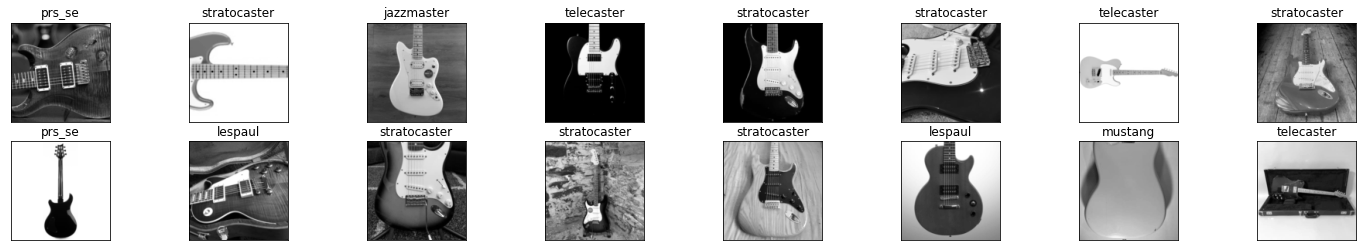

In [3]:
# obtain one batch of training images
dataiter = iter(model_scratch.train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(min(16,model_scratch.batch_size)):
    ax = fig.add_subplot(2, min(16,model_scratch.batch_size)/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(model_scratch.classes[labels[idx]])


Defining the CNN architecture

In [4]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 128x128x1 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # convolutional layer (sees 64x64x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 32x32x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 16x16x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # batch normalisation
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(128)

        # linear layer (128 * 8 * 8 -> 200)
        self.fc1 = nn.Linear(128 * 8 * 8, 200)
        # linear layer (200 -> 7)
        self.fc2 = nn.Linear(200, 7)
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        # After each conv layer, batch normalisation is also applied
        x = self.pool(self.batchnorm1(F.relu(self.conv1(x))))
        x = self.pool(self.batchnorm2(F.relu(self.conv2(x))))
        x = self.pool(self.batchnorm3(F.relu(self.conv3(x))))
        x = self.pool(self.batchnorm4(F.relu(self.conv4(x))))
        # flatten image input
        x = x.view(-1, 128 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer
        x = self.fc2(x)
        return x

# create a complete CNN
model_scratch.set_model(Net(), 'model.pt') 

# specify loss function (categorical cross-entropy)
model_scratch.criterion = nn.CrossEntropyLoss()

# specify optimizer
model_scratch.optimizer = optim.SGD(model_scratch.model.parameters(), lr=0.01)

Training the model with a max of 50 epochs. It stops after 5 epochs with less than 0.02 improvement in the loss.

In [5]:
model_scratch.train_model(max_epochs=50, stop_at=5, stopping_criterion=0.02)

 Epoch: 1 	Training 	100.00% completed
 		Validation 	100.00% completed
		Training Loss: 1.310 	Validation Loss: 1.075
		Validation Accuracy (Overall): 61% (13123/21351)
		Validation loss decreased (inf --> 1.075).  Saving model ...
 Epoch: 2 	Training 	100.00% completed
 		Validation 	100.00% completed
		Training Loss: 1.053 	Validation Loss: 0.914
		Validation Accuracy (Overall): 67% (14371/21351)
		Validation loss decreased (1.075 --> 0.914).  Saving model ...
 Epoch: 3 	Training 	100.00% completed
 		Validation 	100.00% completed
		Training Loss: 0.915 	Validation Loss: 0.811
		Validation Accuracy (Overall): 71% (15284/21351)
		Validation loss decreased (0.914 --> 0.811).  Saving model ...
 Epoch: 4 	Training 	100.00% completed
 		Validation 	100.00% completed
		Training Loss: 0.823 	Validation Loss: 0.737
		Validation Accuracy (Overall): 74% (15888/21351)
		Validation loss decreased (0.811 --> 0.737).  Saving model ...
 Epoch: 5 	Training 	100.00% completed
 		Validation 	100.00% 

This result is after a process of trial and error. The loss decrease follows a nice curve and the model does not seem to be overfitting. It more or less plateaus after 20 epochs. 

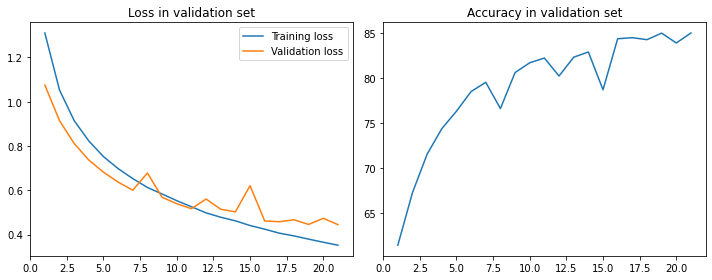

In [6]:
model_scratch.plot_scores()

The overall accuracy in the test set is 84% which is very good considering there are 7 categories. The model performs still quite well on the smaller classes (mustang, jazzmaster, SG)

In [7]:
model_scratch.test_model()

Test Loss: 0.464172

Test Accuracy of jazzmaster: 60% (206/340)
Test Accuracy of lespaul: 90% (1975/2194)
Test Accuracy of mustang: 49% (93/188)
Test Accuracy of prs_se: 85% (1127/1312)
Test Accuracy of    SG: 52% (263/503)
Test Accuracy of stratocaster: 88% (3546/3993)
Test Accuracy of telecaster: 83% (1798/2151)

Test Accuracy (Overall): 84% (9008/10681)


## VGG16

Below I am using the architecture and weights of the VGG16 model and adjusting the end. So basically I am using VGG16 for feature extracting only. The input needs to be the same so it will be colour and sized to 224x224.

In [2]:
model_vgg16 = CNN_trainer()

train_transforms = transforms.Compose([transforms.Resize((224,224)),                                                              
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])]) 

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

#Batch size of 40 is the max my GPU will allow
model_vgg16.get_loaders(40, train_transforms, test_transforms)

CUDA is available!  Training on GPU ...


Getting the VGG16 model and making adjustments to it

In [3]:
vgg16 = models.vgg16_bn(pretrained=True)

model = vgg16

# turning off weight updates in the CNN part
for param in model.features.parameters():
    param.requires_grad = False

#Shortening and changeing the fully connected part
model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])
model.classifier[0] = nn.Dropout(0.6, inplace=False)
model.classifier[1] = nn.Linear(in_features=25088, out_features=4096, bias=True)
model.classifier[2] = nn.ReLU(inplace=True)
model.classifier[3] = nn.Dropout(0.6, inplace=False)
#Change the final parameter to 7 categories
model.classifier[4] = nn.Linear(in_features=4096, out_features=7, bias=True)
    
model_vgg16.set_model(model, 'model_vgg16.pt')

# specify loss function (categorical cross-entropy)
model_vgg16.criterion = nn.CrossEntropyLoss()

# specify optimizer
model_vgg16.optimizer = optim.SGD(model_vgg16.model.parameters(), lr=0.01)

Training the model.

In [4]:
model_vgg16.train_model(max_epochs=40, stop_at=4, stopping_criterion=0.02)

 Epoch: 1 	Training 	100.00% completed
 		Validation 	100.00% completed
		Training Loss: 0.746 	Validation Loss: 0.446
		Validation Accuracy (Overall): 85% (18319/21351)
		Validation loss decreased (inf --> 0.446).  Saving model ...
 Epoch: 2 	Training 	100.00% completed
 		Validation 	100.00% completed
		Training Loss: 0.492 	Validation Loss: 0.387
		Validation Accuracy (Overall): 87% (18678/21351)
		Validation loss decreased (0.446 --> 0.387).  Saving model ...
 Epoch: 3 	Training 	100.00% completed
 		Validation 	100.00% completed
		Training Loss: 0.424 	Validation Loss: 0.350
		Validation Accuracy (Overall): 88% (18897/21351)
		Validation loss decreased (0.387 --> 0.350).  Saving model ...
 Epoch: 4 	Training 	100.00% completed
 		Validation 	100.00% completed
		Training Loss: 0.377 	Validation Loss: 0.328
		Validation Accuracy (Overall): 89% (19046/21351)
		Validation loss decreased (0.350 --> 0.328).  Saving model ...
 Epoch: 5 	Training 	100.00% completed
 		Validation 	100.00% 

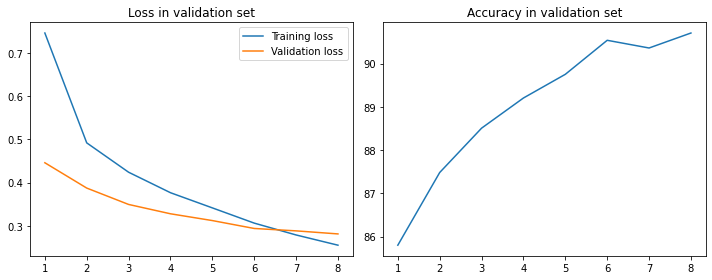

In [5]:
model_vgg16.plot_scores()

Accuracy has improved substantially overall and also the smaller categories are now more accurate. Nevertheless, for this particular dataset it only slightly outperforms my own model.

In [6]:
model_vgg16.test_model()

Test Loss: 0.291624

Test Accuracy of jazzmaster: 73% (248/339)
Test Accuracy of lespaul: 93% (2058/2194)
Test Accuracy of mustang: 66% (125/188)
Test Accuracy of prs_se: 90% (1190/1312)
Test Accuracy of    SG: 75% (380/503)
Test Accuracy of stratocaster: 93% (3720/3993)
Test Accuracy of telecaster: 90% (1953/2151)

Test Accuracy (Overall): 90% (9674/10680)
